In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
import subprocess

# %matplotlib notebook
%matplotlib inline

In [2]:
def barabasi_albert(n=10, m=4):
    G = nx.barabasi_albert_graph(n, m)
    G.graph["dissemination"] = "flooding"
    # compute power
    solving_rate = np.random.exponential(n, n).astype("d")
    for i in range(n):
        G.nodes[i]["compute"] = solving_rate[i] / np.sum(solving_rate)
    # edge distances
    distance = np.random.uniform(low=1, high=3, size=len(G.edges))
    for ((a, b), d) in zip(G.edges, distance):
        G.edges[a, b]["distance"] = d
        G.edges[a, b]["delay"] = f"uniform {d * 0.5} {d * 1.5}"
        G.edges[a, b]["spring_weight"] = 1 / d
    distances = dict(nx.shortest_path_length(G, weight="distance"))
    # closeness / farness metrics
    node_attr = dict()
    for i, d in distances.items():
        farness = sum(d.values()) / (n - 1)
        compute_farness = sum([G.nodes[j]["compute"] * d for j, d in d.items()])
        node_attr[i] = dict(
            farness=farness,
            closeness=1 / farness,
            compute_farness=compute_farness,
            compute_closeness=1 / compute_farness,
        )
    nx.set_node_attributes(G, node_attr)
    # done
    return G


def sim(G, protocol="nakamoto", activation_delay=1, activations=1000, seed=None):
    """
    Run simulator on given network G.
    """
    G = G.copy()
    type_of_node_key = type(list(G.nodes.keys())[0])
    G.graph["activation_delay"] = activation_delay
    G.graph["activations"] = activations
    G.graph["protocol"] = protocol
    if seed:
        G.graph["seed"] = seed
    with subprocess.Popen(
        ["dune", "exec", "graphml_runner"],
        cwd="../..",
        stdin=subprocess.PIPE,
        stdout=subprocess.PIPE,
        text=True,
    ) as process:
        for line in nx.generate_graphml(G):
            try:
                process.stdin.write(line)
            except BrokenPipeError as e:
                pass
        out, err = process.communicate()
        G = nx.parse_graphml(out)
        node_labels = {x: type_of_node_key(x) for x in G.nodes.keys()}
        return nx.relabel_nodes(G, node_labels)


def draw(G, size="compute", layout=None):
    size = dict(G.nodes(data=size)).values()
    size = np.array(list(size)) * 1000
    size = np.interp(size, (size.min(), size.max()), (100, 2000))
    return_layout = False
    if not layout:
        layout = nx.spring_layout(G, weight="spring_weight")
        return_layout = True
    nx.draw(G, pos=layout, node_size=size)
    if return_layout:
        return layout


def print_(G):
    for l in nx.generate_graphml(G):
        print(l)

In [3]:
G = barabasi_albert(n=7)
pd.DataFrame.from_dict(G.nodes, orient="index")

,compute,farness,closeness,compute_farness,compute_closeness
0,0.162919,2.257112,0.443044,2.002281,0.499430
1,0.084533,2.211579,0.452166,1.449716,0.689790
2,0.076157,3.266852,0.306105,2.765645,0.361579
3,0.036848,3.476897,0.287613,3.064756,0.326290
4,0.022326,3.391857,0.294824,2.825558,0.353912
5,0.311630,2.822754,0.354264,1.942737,0.514738
6,0.305587,2.392736,0.417932,1.658255,0.603043


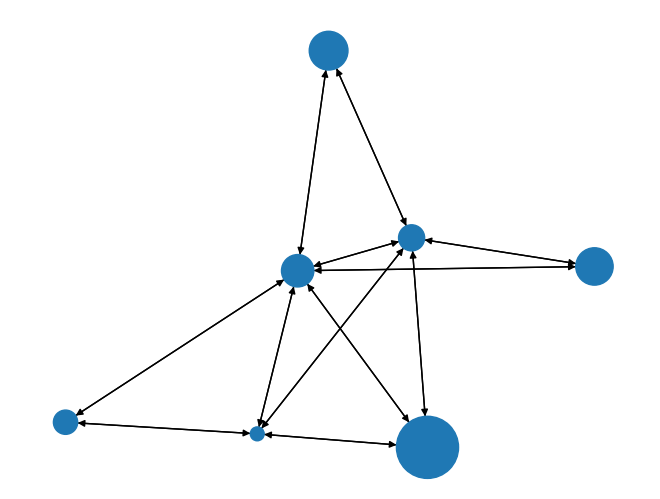

In [4]:
G = sim(barabasi_albert(n=7), activation_delay=1, activations=10000)
layout = draw(G)

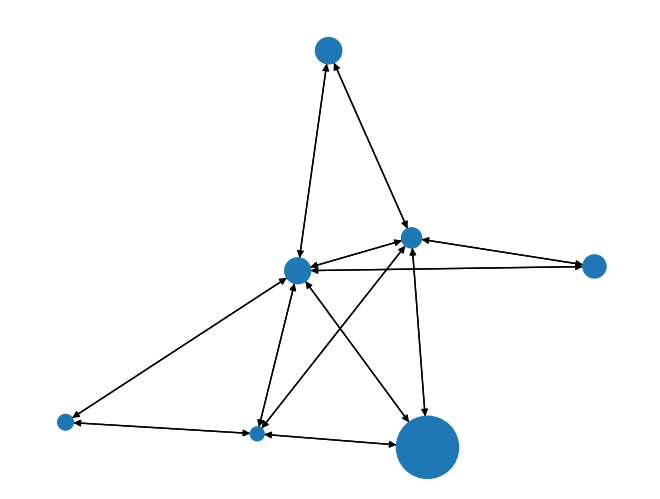

In [5]:
draw(G, size="reward", layout=layout)

In [6]:
runs = []
for i in range(10):
    net = barabasi_albert(n=7)
    cf = dict(G.nodes(data="compute_farness")).values()
    est_progagation_delay = sum(cf) / len(cf)
    for p in [
        "nakamoto",
        "ethereum-discount",
        "tailstorm-8-constant-heuristic",
        "tailstorm-8-discount-optimal",
    ]:
        G = sim(
            net,
            activation_delay=2 * est_progagation_delay,
            activations=1000,
            protocol=p,
            seed=i,
        )
        d = pd.DataFrame.from_dict(G.nodes, orient="index")
        d["protocol"] = p
        runs.append(d)
df = pd.concat(runs)
# calculate metrics
df["relative_reward"] = df.reward / np.sum(df.reward)
df["relative_activations"] = df.reward / np.sum(df.activations)
df["efficiency"] = df.reward / G.graph["head_progress"] / df.compute
df.efficiency.fillna(0, inplace=True)
display(df)

,activations,reward,compute_closeness,compute_farness,closeness,farness,compute,protocol,relative_reward,relative_activations,efficiency
0,19.0,9.000,0.410777,2.434410,0.449895,2.222742,0.018086,nakamoto,0.000266,0.000225,0.550476
1,111.0,35.000,0.239902,4.168376,0.286649,3.488593,0.110176,nakamoto,0.001036,0.000875,0.351409
2,40.0,25.000,0.290420,3.443290,0.352795,2.834510,0.031896,nakamoto,0.000740,0.000625,0.867041
3,62.0,21.000,0.232906,4.293583,0.314558,3.179069,0.057734,nakamoto,0.000622,0.000525,0.402365
4,733.0,707.000,0.955813,1.046230,0.280755,3.561822,0.751259,nakamoto,0.020925,0.017675,1.041026
...,...,...,...,...,...,...,...,...,...,...,...
2,378.0,249.750,0.431838,2.315681,0.243361,4.109125,0.438834,tailstorm-8-discount-optimal,0.007392,0.006244,0.629559
3,3.0,2.125,0.266602,3.750906,0.326460,3.063159,0.002460,tailstorm-8-discount-optimal,0.000063,0.000053,0.955654
4,183.0,122.250,0.368857,2.711077,0.386746,2.585677,0.160181,tailstorm-8-discount-optimal,0.003618,0.003056,0.844246
5,115.0,73.750,0.360313,2.775366,0.389652,2.566390,0.098743,tailstorm-8-discount-optimal,0.002183,0.001844,0.826206


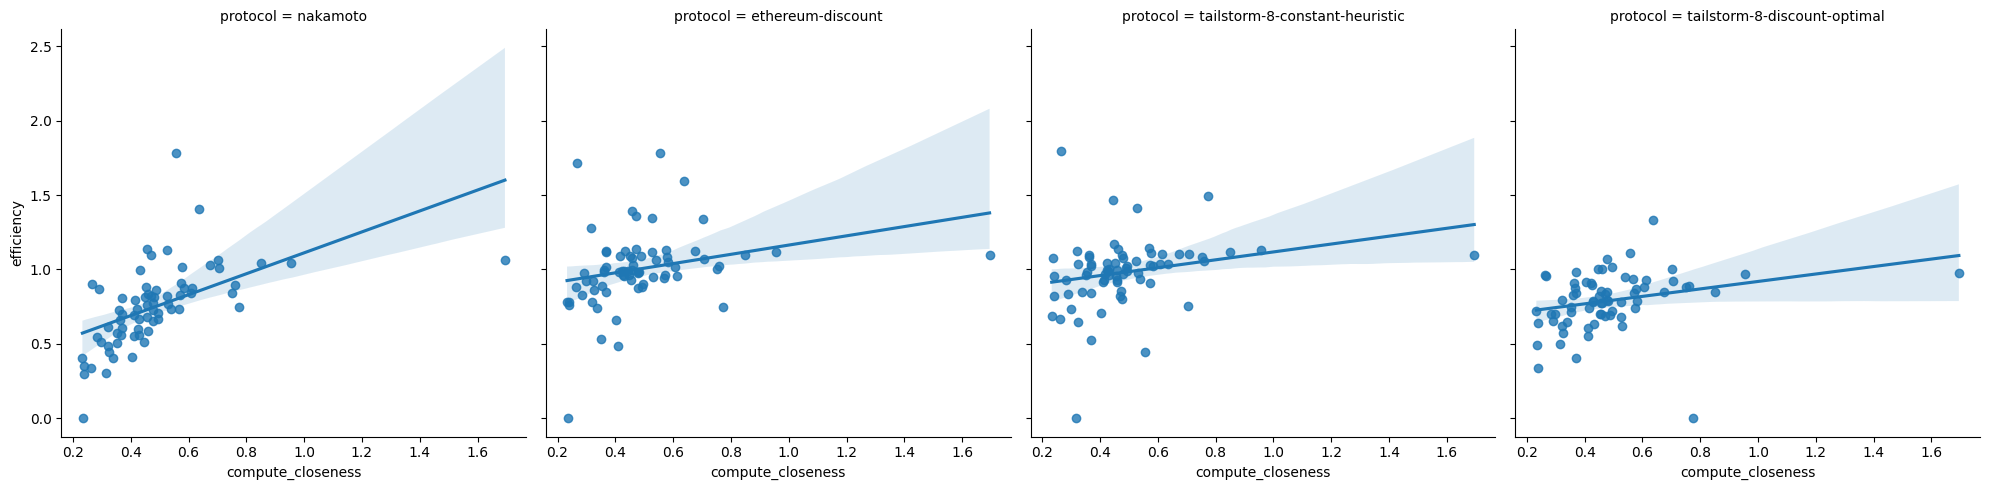

In [7]:
sns.lmplot(data=df, x="compute_closeness", y="efficiency", col="protocol")